# Profiling

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.utils import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset

%load_ext pyinstrument
%load_ext line_profiler

# Information system and libraries

In [3]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.11.10
scikit-learn version: 1.6.1
skforecast version: 0.16.0
pandas version: 2.2.3
numpy version: 2.1.3
scipy version: 1.15.2
psutil version: 7.0.0

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19045-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19045
Number of physical cores: 8
Number of logical cores: 16


# ForecasterAutoregMultiSeries

In [12]:
n_series = 1000
len_series = (2000, 5000)
series_dict = {}
rng = np.random.default_rng(321)
for i in range(n_series):
    n = rng.integers(low=len_series[0], high=len_series[1])
    series_dict[f'series_{i}'] = pd.Series(
        data = rng.normal(loc=20, scale=5, size=n),
        index=pd.date_range(
            start='2010-01-01',
            periods=n,
            freq='h'
        ),
        name=f'series_{i}'
    )

exog_dict = {}
rng = np.random.default_rng(321)
for k in series_dict.keys():
    exog = pd.DataFrame(
            index=series_dict[k].index
            )
    exog['day_of_week'] = exog.index.dayofweek
    exog['week_of_year'] = exog.index.isocalendar().week.astype(int)
    exog['month'] = exog.index.month
    exog_dict[k] = exog


print(f"Range of dates: "
    f"{np.min([series_dict[k].index.min() for k in series_dict.keys()])} - "
    f"{np.max([series_dict[k].index.max() for k in series_dict.keys()])}"
)

Range of dates: 2010-01-01 00:00:00 - 2010-07-27 22:00:00


In [13]:
end_train = '2010-06-01 00:00:00'

In [14]:
# Forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=8520, verbose=-1),
    lags=50,
    # transformer_series=StandardScaler(),
    # transformer_exog=StandardScaler(),
    encoding="ordinal"
)

In [15]:
# %%timeit -n 5 -r 5

# forecaster.fit(series=series_dict, exog=exog_dict)

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:00:18  Samples:  6725
 /_//_/// /_\ / //_// / //_'/ //     Duration: 34.637    CPU time: 120.781
/   _/                      v5.0.0

Cell [16]

34.636 <module>  ..\..\AppData\Local\Temp\ipykernel_26628\3804324935.py:1
`- 34.634 ForecasterRecursiveMultiSeries.fit  skforecast\recursive\_forecaster_recursive_multiseries.py:1642
   |- 17.327 LGBMRegressor.fit  lightgbm\sklearn.py:1172
   |     [14 frames hidden]  lightgbm, <built-in>, pandas
   |        9.863 Booster.update  lightgbm\basic.py:4073
   |- 5.209 ForecasterRecursiveMultiSeries._create_train_X_y  skforecast\recursive\_forecaster_recursive_multiseries.py:962
   |  |- 2.487 concat  pandas\core\reshape\concat.py:157
   |  |     [8 frames hidden]  pandas, <built-in>
   |  |- 1.232 ForecasterRecursiveMultiSeries._create_train_X_y_single_series  skforecast\recursive\_forecaster_recursive_multiseries.py:837
   |  |  `- 0.633 ForecasterRecursiveMultiSeries._create_lags  skforecast\recursive\_forecaster_recursive_multiseries.py:725
   |  `- 0.418 DataFrame.isnull  pandas\core\frame.py:6494
   |        [7 frames hidden]  pandas
   |- 4.069 Series.__getitem__  pandas\core\series.py:1095
   |     [6 frames hidden]  pandas
   |- 4.035 [self]  skforecast\recursive\_forecaster_recursive_multiseries.py
   |- 2.615 LGBMRegressor.predict  lightgbm\sklearn.py:992
   |     [11 frames hidden]  lightgbm, <built-in>, pandas
   `- 1.078 ForecasterRecursiveMultiSeries._binning_in_sample_residuals  skforecast\recursive\_forecaster_recursive_multiseries.py:1826
      |- 0.510 DataFrame.__init__  pandas\core\frame.py:694
      |  `- 0.465 dict_to_mgr  pandas\core\internals\construction.py:423
      `- 0.438 QuantileBinner.fit  skforecast\preprocessing\preprocessing.py:1482
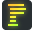

In [16]:
%%pyinstrument

forecaster.fit(series=series_dict, exog=exog_dict)

In [18]:
# Profiling fit()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster.fit(series=series, exog=exog)

%lprun -f forecaster.fit funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-07 s

Total time: 28.4939 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: fit at line 1642

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1642                                               def fit(
  1643                                                   self,
  1644                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
  1645                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  1646                                                   store_last_window: bool | list[str] = True,
  1647                                                   store_in_sample_residuals: bool = False,
  1648                                                   random_state: int = 123,
  1649                                                   suppress_warnings: bool = False
  1650         

In [17]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster._create_train_X_y(series=series, exog=exog)

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-07 s

Total time: 4.41229 s
File: c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py
Function: _create_train_X_y at line 962

Line #      Hits         Time  Per Hit   % Time  Line Contents
   962                                               def _create_train_X_y(
   963                                                   self,
   964                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   965                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
   966                                                   store_last_window: bool | list[str] = True,
   967                                               ) -> tuple[
   968                                                   pd.DataFrame,
   969                                                   pd.Series,
   970                                               

In [11]:
# Profiling _create_train_X_y_single_series()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    (
    X_train_autoreg,
    X_train_window_features_names_out_,
    X_train_exog,
    y_train
) = forecaster._create_train_X_y_single_series(
        y = series,
        exog = exog,
        ignore_exog = False,
    )

%lprun -f forecaster._create_train_X_y_single_series funt_to_profile(forecaster, series_dict['series_0'], exog_dict['series_0'])

SyntaxError: unexpected character after line continuation character (<string>, line 1)

In [ ]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    forecaster.predict(steps=steps, exog=exog, suppress_warnings=True)

%lprun -f forecaster.predict funt_to_profile(forecaster, 7, exog_dict_valid)

Timer unit: 1e-09 s

Total time: 36.6131 s
File: /home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py
Function: predict at line 1537

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1537                                               def predict(
  1538                                                   self,
  1539                                                   steps: int,
  1540                                                   levels: Optional[Union[str, list]]=None,
  1541                                                   last_window: Optional[pd.DataFrame]=None,
  1542                                                   exog: Optional[Union[pd.Series, pd.DataFrame, dict]]=None,
  1543                                                   suppress_warnings: bool=False
  1544                                               ) -> pd.DataFrame:
  1545                                                   """
  1546                

: 

: 

: 

In [ ]:
# Functions to profile:
# ==============================================================================
# check_preprocess_exog_multiseries
# align_series_and_exog_multiseries
# _create_train_X_y_single_series
# _create_predict_inputs
# _recursive_predict

: 

: 

In [ ]:
# Profiling align_series_and_exog_multiseries()
# ==============================================================================
# def funt_to_profile(series_dict, input_series_is_dict, exog_dict):
#     align_series_and_exog_multiseries(
#         series_dict=series_dict,
#         input_series_is_dict=input_series_is_dict,
#         exog_dict = exog_dict,
#     )

# %lprun -f align_series_and_exog_multiseries funt_to_profile(series_dict_train, True, exog_dict_train)

: 

: 

In [ ]:
# # Profiling check_preprocess_exog_multiseries()
# # ==============================================================================
# series_indexes = {k: v.index for k, v  in series_dict_train.items()}
# series_col_names = list(series_dict_train.keys())

# def funt_to_profile(input_series_is_dict, series_indexes, series_col_names, exog, exog_dict):
#     check_preprocess_exog_multiseries(
#         input_series_is_dict = input_series_is_dict,
#         series_indexes = series_indexes,
#         series_col_names = series_col_names,
#         exog = exog_dict_train,
#         exog_dict = exog_dict_train,
#     )

# %lprun -f check_preprocess_exog_multiseries funt_to_profile(True, series_indexes, series_col_names, exog, exog_dict)

: 

: 

In [ ]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(data):
    fast_encoder.fit(data)

data_np = data['y'].to_numpy()
%lprun -f fast_encoder.fit funt_to_profile(data_np)

KeyError: 'y'